# Import Statements

In [157]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
%matplotlib inline

import random
from pprint import pprint 

# Load and Prepare Data

### Format of the data

1. last column of the data must contain the label and if must also be called "label"
2. there shoud be no missing values in the data frame

In [158]:
df=pd.read_csv('Iris.csv')
df=df.drop("Id",axis=1)
df=df.rename(columns={"Species": "label","PetalWidthCm": "petal_Width","PetalLengthCm": "petal_length",
                      "SepalWidthCm":"sepal_width","SepalLengthCm":"sepal_length"})

# Train-Test_Split

In [159]:
def train_test_split(df,test_size):
    if isinstance(test_size,float):
        test_size=round(test_size*len(df))

    indices=df.index.tolist()
    test_indices=random.sample(population=indices,k=test_size)

    test_df=df.loc[test_indices]
    train_df=df.drop(test_indices)
    return train_df, test_df
random.seed(0)
train_df,test_df=train_test_split(df,test_size=10)
test_df.head()

,sepal_length,sepal_width,petal_length,petal_Width,label
98,5.1,2.5,3.0,1.1,Iris-versicolor
107,7.3,2.9,6.3,1.8,Iris-virginica
10,5.4,3.7,1.5,0.2,Iris-setosa
66,5.6,3.0,4.5,1.5,Iris-versicolor
130,7.4,2.8,6.1,1.9,Iris-virginica


# Data Pure

In [160]:
data=train_df.values
#converting data to numpy (faster than pandas)
def check_purity(data):
    label_column=data[:,-1]
    unique_classes=np.unique(label_column)
    if len(unique_classes)==1:
        return True
    else:
        return False

# Classify

In [161]:
def classify_data(data):
    label_column=data[:,-1]
    unique_classes,counts_unique_classes=np.unique(label_column,return_counts=True)
    index=counts_unique_classes.argmax()
    classificaion=unique_classes[index]
    return classificaion
classify_data(train_df[train_df.petal_Width>0.8].values)

'Iris-versicolor'

# Potential splits

In [163]:
train_df.head()

,sepal_length,sepal_width,petal_length,petal_Width,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [171]:

def get_potential_splits(data):
    potential_splits={}
    _,n_columns=data.shape
    for column_index in range(n_columns-1):
        potential_splits[column_index]=[]
        values=data[:,column_index]
        unique_values=np.unique(values)

        for index in range(len(unique_values)):
            if index!=0:
                current_value=unique_values[index]
                previous_value=unique_values[index-1]
                potential_split=(current_value+previous_value)/2
                potential_splits[column_index].append(potential_split)

    return potential_splits

potential_splits=get_potential_splits(train_df.values)
    

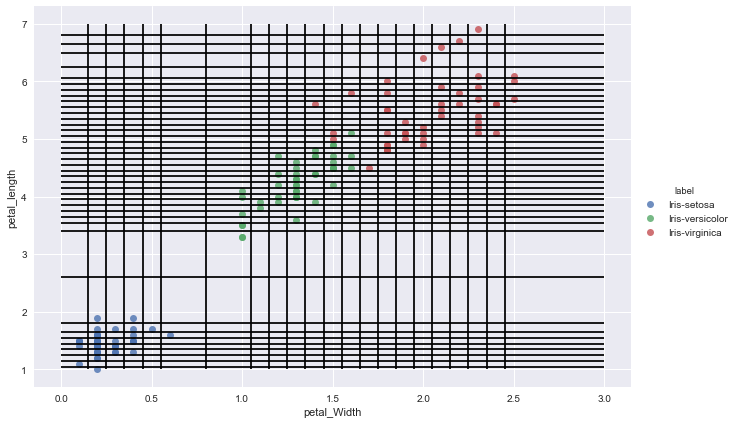

In [179]:
sns.lmplot(data=train_df,x='petal_Width',y='petal_length',hue='label',fit_reg=False,size=6,aspect=1.5)

plt.pyplot.vlines(x=potential_splits[3],ymin=1,ymax=7)
plt.pyplot.hlines(y=potential_splits[2],xmin=0,xmax=3)

# Split data

In [244]:
#split_column=3
#split_value=1.05

def split_data(data,split_column,split_value):
    split_column_values=data[:,split_column]
    
    data_below=data[split_column_values<=split_value]
    data_above=data[split_column_values>split_value]
    
    return data_below,data_above


In [245]:
data_below,data_above=split_data(data,split_column,split_value)

(0, 2.6)

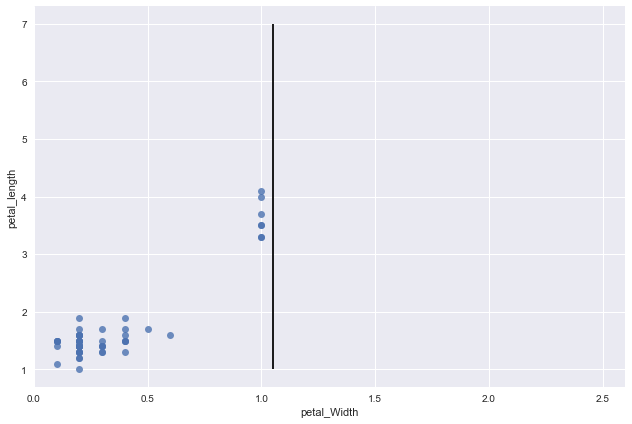

In [246]:
plotting_df=pd.DataFrame(data_below,columns=df.columns)
sns.lmplot(data=plotting_df,x="petal_Width",y="petal_length",fit_reg=False,size=6,aspect=1.5)
plt.pyplot.vlines(split_value,ymin=1,ymax=7)
plt.pyplot.xlim(0,2.6)

# Lowest overall Entropy

In [247]:
def calculate_entropy(data):
    label_column=data[:,-1]
    _,counts=np.unique(label_column,return_counts=True)

    probabilities=counts/counts.sum()
    entropy=sum(probabilities* -np.log2(probabilities))
    
    return entropy

In [248]:
def calculate_overall_entropy(data_below,data_above):
    n_data_points=len(data_below)+len(data_above)
    
    p_data_below=len(data_below)/n_data_points
    p_data_above=len(data_above)/n_data_points
    
    overall_entropy=(p_data_below*calculate_entropy(data_below)+
                    p_data_above*calculate_entropy(data_above))
    return overall_entropy
    

In [249]:
calculate_overall_entropy(data_below,data_above)

0.8152156890152158

In [250]:
def determine_best_split(data,potential_splits):
    overall_entropy=999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below,data_above=split_data(data,split_column=column_index,split_value=value)
            current_overall_entropy=calculate_overall_entropy(data_below,data_above)
            
            if current_overall_entropy<=overall_entropy:
                overall_entropy=current_overall_entropy
                best_split_column=column_index
                best_split_value=value  
            
    return best_split_column,best_split_value

In [251]:
potential_splits=get_potential_splits(data)
determine_best_split(data,potential_splits)

(3, 0.8)

# Decison Tree Algorithm

### Representation of the Decision tree

In [353]:
#sub_tree={question:[yes_ans,no_ans]}
example_tree={"petal_width<=0.8":["Iris-setosa",
                                  {"petal_width<=1.65":[{"petal_legth<=4.9":
                                                         ["Iris_versicolor",
                                                          "Iris_virginica"]},
                                                        "Iris_virginica"]}]}

In [370]:
def decision_tree_algorithm(df,counter=0):
    #data preparation
    if counter==0:
        data=df.values
    else:
        data=df
        
    # base case
    if check_purity(data):
        classification=classify_data(data)
        return classification
    #recursive part
    else:
        counter +=1
        #helper functions
        potential_splits=get_potential_splits(data)
        split_column,split_value=determine_best_split(data,potential_splits)

        data_below,data_above=split_data(data,split_column,split_value)
        #instantiate sub tree
        question="{}<={}".format(split_column,split_value)
        sub_tree={question:[]}
        
        #find ans(recursion)
        yes_answer=decision_tree_algorithm(data_below,counter)
        no_answer=decision_tree_algorithm(data_above,counter)
        
        sub_tree[question].append(yes_answer)
        sub_tree[question].append(no_answer)
        
        return sub_tree
        

In [371]:
tree=decision_tree_algorithm(train_df[train_df.label!='iris-virginica'])

In [375]:
pprint(tree)

{'3<=0.8': ['Iris-setosa',
            {'3<=1.65': [{'2<=4.95': ['Iris-versicolor',
                                      {'3<=1.55': ['Iris-virginica',
                                                   {'2<=5.449999999999999': ['Iris-versicolor',
                                                                             'Iris-virginica']}]}]},
                         {'2<=4.85': [{'1<=3.1': ['Iris-virginica',
                                                  'Iris-versicolor']},
                                      'Iris-virginica']}]}]}


In [374]:
np.unique(df.label)

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)